<h1><center>CNN Cancer Detection Kaggle Mini-Project</center></h1>
<h2><center>Introduction to Deep Learning</center></h2>
<h3><center>DTSA-5511</center></h3>
<h3><center>University of Colorado Boulder</center></h3>
<h3><center>D. Stephen Haynes</center></h3>

# Histopathologic Cancer Detection
- This project will use Convolution Neural Network (CNN) methods to identify metastatic cancer in small image patches as an entry into Kaggle's Histopathologic Cancer Detection Competition.
- The details and datasets related to this competition are available here: https://www.kaggle.com/c/histopathologic-cancer-detection/overview

- The code below will perform the following:
    - Ingest the training labels provided as part of the competition
    - Ingest the file locations for the training and test images
    - Align the training labels with the matching training images
    - Evaluate the datasets for size, label distribution, and image dimensions
    - Visualize samples from both classes of training data
    - Using the details collected, load the training images and train a CNN model
    - Split the training data into training and validation sets to evaluate labeling accuracy
    - Adjust the model architecture and parameters and iterate through model evaluation to discover improvements
    - Apply the most accurate model to the test data and output the labeling results for submission to Kaggle
- The file will be submitted to the Kaggle competition for evaluation and ranking once the test data has been labeled.

## Convolution Neural Network (CNN)
- Convolution Neural Networks are a class of deep learning neural networks most commonly used in visual image analysis. The most significant benefit of CNNs is their ability to automatically detect important features or patterns in images without human supervision. CNNs are comprised of multiple processing layers, described here:
    Convolution Layers: These layers are the method's namesake and apply several filters to the input. Each filter detects different features by performing a convolution operation between filter and input, producing a feature map that captures the local dependencies in the original image.
    - Pooling Layers: These layers reduce the width and height of the input for the following convolution layer, decreasing the computational power needed to process the data. Pooling layers also assist by extracting dominant features that are positionally invariant, creating a more robust feature detection solution.
    - Fully Connected Layers: This layer performs the high-level reasoning in the neural network. Neurons in a fully connected layer have complete connections to all activations in the previous layer.

## The Dataset
The data provided as part of the Kaggle Competition comprises over 275,000 images. 220,000 of these images constitute the training portion of the data, accompanied by a single CSV file that provides labels for each image file.
- The code below will load the data and output initial details of the datasets before evaluation.

In [1]:
# Import necessary libraries
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns
import os
from collections import Counter
from PIL import Image
import random
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

In [2]:
# Check that we are using TensorFlow with GPU
print("TensorFlow version:", tf.__version__)
print("Num GPUs Available:", len(tf.config.experimental.list_physical_devices('GPU')))

TensorFlow version: 2.10.1
Num GPUs Available: 1


In [3]:
# Load the training labels and review headers
train_labels = pd.read_csv("C:/cancer/train_labels.csv")
train_labels.head()

,id,label
0,f38a6374c348f90b587e046aac6079959adf3835,0
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77,1
2,755db6279dae599ebb4d39a9123cce439965282d,0
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08,0
4,068aba587a4950175d04c680d38943fd488d6a9d,0


In [4]:
# Show info on training label dataframe
train_labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 220025 entries, 0 to 220024
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   id      220025 non-null  object
 1   label   220025 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 3.4+ MB


In [5]:
# Define path to train/test images and verify number of files
train_path = "C:/cancer/train"
test_path = "C:/cancer/test"

print("Number of training images:", len(os.listdir(train_path)))
print("Number of test images:", len(os.listdir(test_path)))

Number of training images: 220025
Number of test images: 57458


# Exploratory Data Analysis (EDA)
- We'll start off by visualizing the distribution of training labels and displaying some sample images from the training data. Then, we'll evaluate the dimensions of the images in both training and test datasets to determine the best settings for our model.
-  Training images labeled with a 0 are benign or non-cancerous. Those labeled with a 1 are malignant or cancerous.

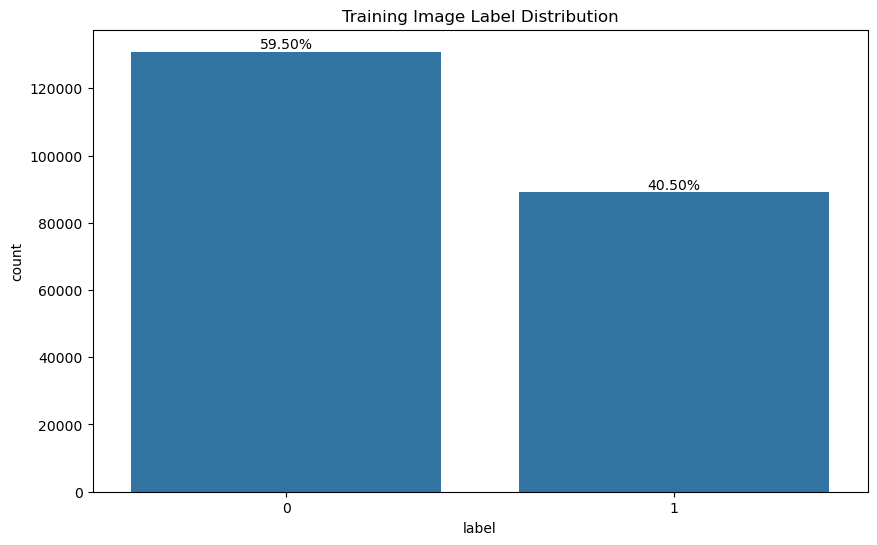

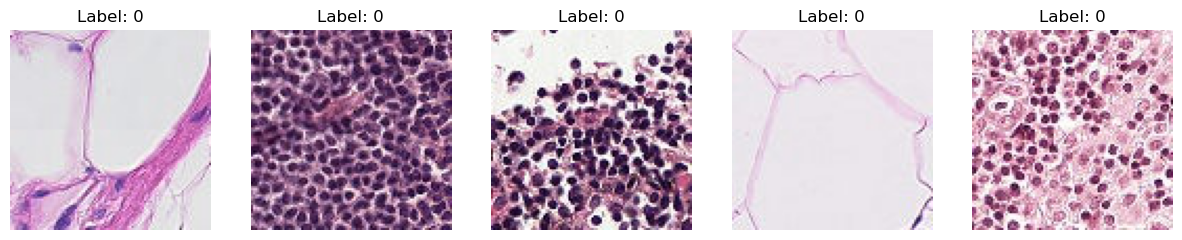

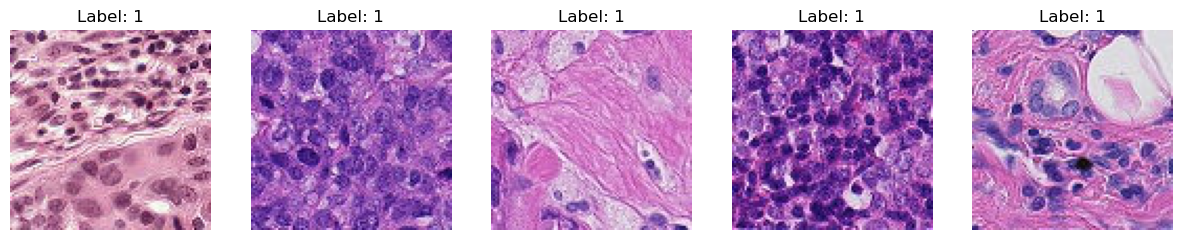

In [6]:
# Calculate percentage of each label
label_counts = train_labels['label'].value_counts()
total_count = len(train_labels)
label_percentages = (label_counts / total_count) * 100

# Plot the label distribution
plt.figure(figsize=(10, 6))
ax = sns.countplot(x='label', data=train_labels)
plt.title("Training Image Label Distribution")

# Annotate with percentages
for p in ax.patches:
    height = p.get_height()
    percentage = label_percentages[p.get_x() + p.get_width() / 2.0]
    ax.annotate(f'{percentage:.2f}%', (p.get_x() + p.get_width() / 2., height), 
                ha='center', va='bottom')

plt.show()

# Function to load and display a few sample images
def display_sample_images(data, label, path, num_samples=5):
    sample_ids = data[data['label'] == label]['id'].sample(num_samples)
    plt.figure(figsize=(15, 5))
    for i, img_id in enumerate(sample_ids):
        img = Image.open(os.path.join(path, f"{img_id}.tif"))
        plt.subplot(1, num_samples, i+1)
        plt.imshow(img)
        plt.title(f"Label: {label}")
        plt.axis('off')
    plt.show()

# Display sample images for each label
display_sample_images(train_labels, 0, train_path)
display_sample_images(train_labels, 1, train_path)

In [7]:
# Function to collect image dimensions
def get_image_dimensions(image_path):
    with Image.open(image_path) as img:
        width, height = img.size
        depth = len(img.getbands())
        return width, height, depth

# Function to collect image dimensions from a sample
def check_image_dimensions(directory, num_samples=5):
    img_files = os.listdir(directory)
    
    if num_samples is not None:
        img_files = random.sample(img_files, min(num_samples, len(img_files)))
    
    dimensions = [get_image_dimensions(os.path.join(directory, img_id)) for img_id in img_files]
    return dimensions

# Check dimensions of a sample of 5 training images
train_dimensions = check_image_dimensions(train_path)
# Check dimensions of a sample of 5 test images
test_dimensions = check_image_dimensions(test_path)

# Print out the dimensions of the sampled images
print("Sample train image dimensions:", train_dimensions)
print("Sample test image dimensions:", test_dimensions)

# Print out the most common dimensions in each dataset sample
train_dim_counter = Counter(train_dimensions)
test_dim_counter = Counter(test_dimensions)

print("Most common train image dimensions (sample):", train_dim_counter.most_common(5))
print("Most common test image dimensions (sample):", test_dim_counter.most_common(5))

Sample train image dimensions: [(96, 96, 3), (96, 96, 3), (96, 96, 3), (96, 96, 3), (96, 96, 3)]
Sample test image dimensions: [(96, 96, 3), (96, 96, 3), (96, 96, 3), (96, 96, 3), (96, 96, 3)]
Most common train image dimensions (sample): [((96, 96, 3), 5)]
Most common test image dimensions (sample): [((96, 96, 3), 5)]


## EDA Results
- Based on the label distribution above, we can see that the training images are 60% benign and 40% malignant. The sample images and dimensions are shown to ensure everything is consistent for both label types. The differences between benign and malignant images seem minimal, but we are leveraging a CNN model to help identify patterns that may not be obvious to the human eye. The image dimension details inform us that we can anticipate images that are 96 pixels wide and 96 pixels high, and they contain three layers, which is consistent with RGB images. We will build our model with these parameters in mind.

# Model Architecture
- We want to train our model with as much variety as possible to detect the various patterns in these images. To achieve this, we will randomly augment each image with rotation, flipping, and scaling transformations. This will ensure our model is more generalized and better suited for identifying patterns correctly. We will also add a function to resize images to 96x96 in the case that some images are inconsistent with the complete set.
- Our model, a Convolution Neural Network, is a powerful tool for image classification. Its architecture, comprising convolution layers, pooling layers, and fully connected layers, is designed to process and interpret image data effectively. We will train this model on the complete set of training images, using an 80/20 split of training and validation images. Once trained, we will assess its performance using accuracy and loss measurements, determining its readiness for the test data.
- Once we have determined that the model is appropriately designed, we will apply it to the test data. The model will evaluate each test image, detect the patterns within, and then provide a score to be rounded up or down to designate the image as benign (0) or malignant (1). As we did previously for the training data, we will again display the label distribution and some sample images for the test set. The test label data frame will also be saved and exported as a CSV file to be submitted to the Kaggle competition.

In [8]:
# Define the image data generator for data augmentation
datagen = ImageDataGenerator(
    rescale=1.0/255.0,
    rotation_range=20, # 20°
    width_shift_range=0.2, # 20%
    height_shift_range=0.2, # 20%
    horizontal_flip=True, # random flipping
    vertical_flip=True, # random flipping
    validation_split=0.2 # 80/20 split
)

# Load and preprocess images
def load_images(data, path):
    images = []
    labels = []
    for _, row in data.iterrows():
        img = Image.open(os.path.join(path, f"{row['id']}.tif"))
        img = img.resize((96, 96))
        img = np.array(img)
        images.append(img)
        labels.append(row['label'])
    return np.array(images), np.array(labels)

# Load training images
X_train, y_train = load_images(train_labels, train_path)

In [9]:
# Model architecture
def create_model():
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=(96, 96, 3)),
        MaxPooling2D((2, 2)),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Conv2D(128, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Flatten(),
        Dense(512, activation='relu'),
        Dropout(0.5),
        Dense(1, activation='sigmoid')
    ])
    
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

model = create_model()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 94, 94, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 47, 47, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 45, 45, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 22, 22, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 20, 20, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 10, 10, 128)      0

In [10]:
# Split data into training and validation sets
split_idx = int(0.8 * len(X_train))
X_val, y_val = X_train[split_idx:], y_train[split_idx:]
X_train, y_train = X_train[:split_idx], y_train[:split_idx]

# Data augmentation
train_generator = datagen.flow(X_train, y_train, batch_size=32, subset='training')
val_generator = datagen.flow(X_val, y_val, batch_size=32, subset='validation')

# Train the model
history = model.fit(train_generator, validation_data=val_generator, epochs=10)

# Save the model
model.save('tumor_classifier.h5')

Epoch 1/10
4401/4401 [==============================] - 164s 37ms/step - loss: 0.4493 - accuracy: 0.7951 - val_loss: 0.4365 - val_accuracy: 0.8057
Epoch 2/10
4401/4401 [==============================] - 164s 37ms/step - loss: 0.3668 - accuracy: 0.8396 - val_loss: 0.3509 - val_accuracy: 0.8543
Epoch 3/10
4401/4401 [==============================] - 163s 37ms/step - loss: 0.3395 - accuracy: 0.8546 - val_loss: 0.3120 - val_accuracy: 0.8697
Epoch 4/10
4401/4401 [==============================] - 162s 37ms/step - loss: 0.3240 - accuracy: 0.8626 - val_loss: 0.3257 - val_accuracy: 0.8616
Epoch 5/10
4401/4401 [==============================] - 160s 36ms/step - loss: 0.3112 - accuracy: 0.8691 - val_loss: 0.3019 - val_accuracy: 0.8768
Epoch 6/10
4401/4401 [==============================] - 163s 37ms/step - loss: 0.3024 - accuracy: 0.8738 - val_loss: 0.2847 - val_accuracy: 0.8826
Epoch 7/10
4401/4401 [==============================] - 161s 36ms/step - loss: 0.2982 - accuracy: 0.8766 - val_loss: 0

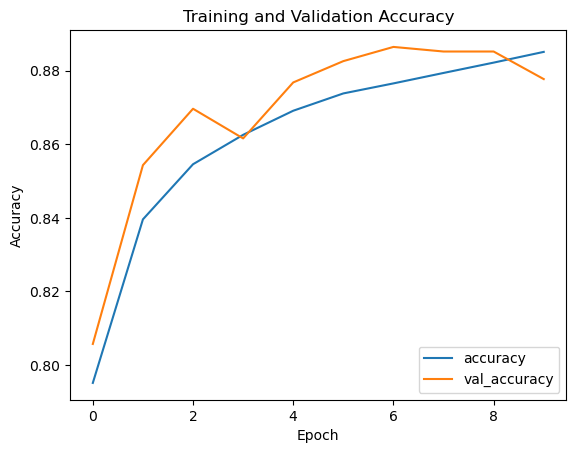

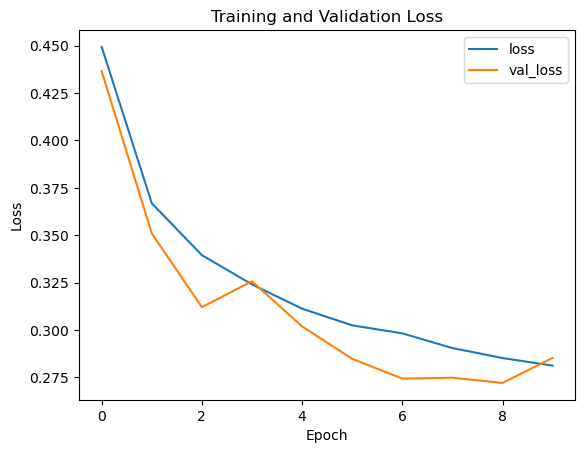

276/276 [==============================] - 10s 34ms/step - loss: 0.2740 - accuracy: 0.8851
Validation accuracy: 0.89
Validation loss: 0.27


In [11]:
# Plot training history
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.show()

plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

# Evaluate the model on validation data
val_loss, val_accuracy = model.evaluate(val_generator)
print(f"Validation accuracy: {val_accuracy:.2f}")
print(f"Validation loss: {val_loss:.2f}")

Based on the plots above, we achieved 88.5% accuracy when training the model with ten epochs.

Let's adjust the number of epochs when fitting the model to see if we can improve the accuracy.

In [12]:
# Train the second model with 25 epochs
history2 = model.fit(train_generator, validation_data=val_generator, epochs=20)

# Save the second model
model.save('tumor_classifier2.h5')

Epoch 1/20
4401/4401 [==============================] - 160s 36ms/step - loss: 0.2785 - accuracy: 0.8859 - val_loss: 0.2577 - val_accuracy: 0.8932
Epoch 2/20
4401/4401 [==============================] - 160s 36ms/step - loss: 0.2752 - accuracy: 0.8881 - val_loss: 0.2620 - val_accuracy: 0.8988
Epoch 3/20
4401/4401 [==============================] - 161s 36ms/step - loss: 0.2728 - accuracy: 0.8901 - val_loss: 0.2602 - val_accuracy: 0.8963
Epoch 4/20
4401/4401 [==============================] - 161s 37ms/step - loss: 0.2721 - accuracy: 0.8900 - val_loss: 0.2555 - val_accuracy: 0.8968
Epoch 5/20
4401/4401 [==============================] - 159s 36ms/step - loss: 0.2701 - accuracy: 0.8913 - val_loss: 0.2596 - val_accuracy: 0.8947
Epoch 6/20
4401/4401 [==============================] - 160s 36ms/step - loss: 0.2675 - accuracy: 0.8917 - val_loss: 0.2721 - val_accuracy: 0.8865
Epoch 7/20
4401/4401 [==============================] - 159s 36ms/step - loss: 0.2643 - accuracy: 0.8941 - val_loss: 0

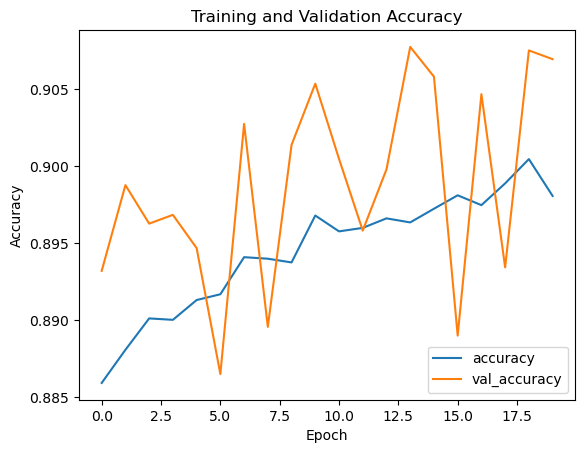

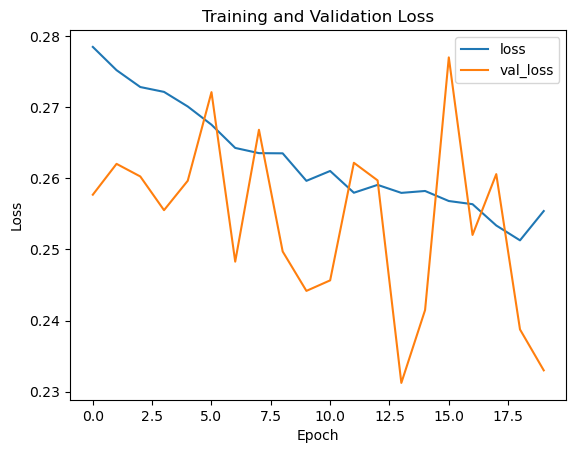

276/276 [==============================] - 9s 34ms/step - loss: 0.2382 - accuracy: 0.9055
Validation accuracy: 0.91
Validation loss: 0.24


In [14]:
# Plot training history
plt.plot(history2.history['accuracy'], label='accuracy')
plt.plot(history2.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.show()

plt.plot(history2.history['loss'], label='loss')
plt.plot(history2.history['val_loss'], label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

# Evaluate the model on validation data
val_loss, val_accuracy = model.evaluate(val_generator)
print(f"Validation accuracy: {val_accuracy:.2f}")
print(f"Validation loss: {val_loss:.2f}")

Doubling the number of epochs for the second model provided an accuracy gain of 2% for 90.5%.
We'll use this second training for the test data. This will be done in batches to prevent overloading machine memory during processing.

In [15]:
# Batch prediction function
def batch_predict(model, test_path, batch_size=320):
    test_images = []
    test_ids = []
    predictions = []
    
    # List all test image files
    test_files = os.listdir(test_path)
    
    for i, img_id in enumerate(test_files):
        img = Image.open(os.path.join(test_path, img_id))
        img = img.resize((96, 96))
        img = np.array(img) / 255.0  # Normalize image
        test_images.append(img)
        test_ids.append(img_id.split('.')[0])  # Extract the ID without the file extension
        
        # When the batch is full, predict and reset
        if len(test_images) == batch_size:
            test_images = np.array(test_images)
            batch_predictions = model.predict(test_images)
            predictions.extend(batch_predictions)
            test_images = []
    
    # Predict the remaining images that don't fill a batch
    if test_images:
        test_images = np.array(test_images)
        batch_predictions = model.predict(test_images)
        predictions.extend(batch_predictions)
    
    return np.array(predictions).flatten(), test_ids

In [16]:
# Predict in batches
predictions, test_ids = batch_predict(model, test_path)

# Convert probabilities to binary labels using a threshold of 0.5
binary_predictions = (predictions >= 0.5).astype(int)

# Create a DataFrame with test IDs and corresponding predictions
submission = pd.DataFrame({'id': test_ids, 'label': binary_predictions})

# Save the submission file
submission.to_csv('submission.csv', index=False)

print("Submission file saved successfully!")

6/6 [==============================] - 0s 17ms/step
Submission file saved successfully!


In [17]:
submission.head()

,id,label
0,00006537328c33e284c973d7b39d340809f7271b,1
1,0000ec92553fda4ce39889f9226ace43cae3364e,1
2,00024a6dee61f12f7856b0fc6be20bc7a48ba3d2,0
3,000253dfaa0be9d0d100283b22284ab2f6b643f6,0
4,000270442cc15af719583a8172c87cd2bd9c7746,0


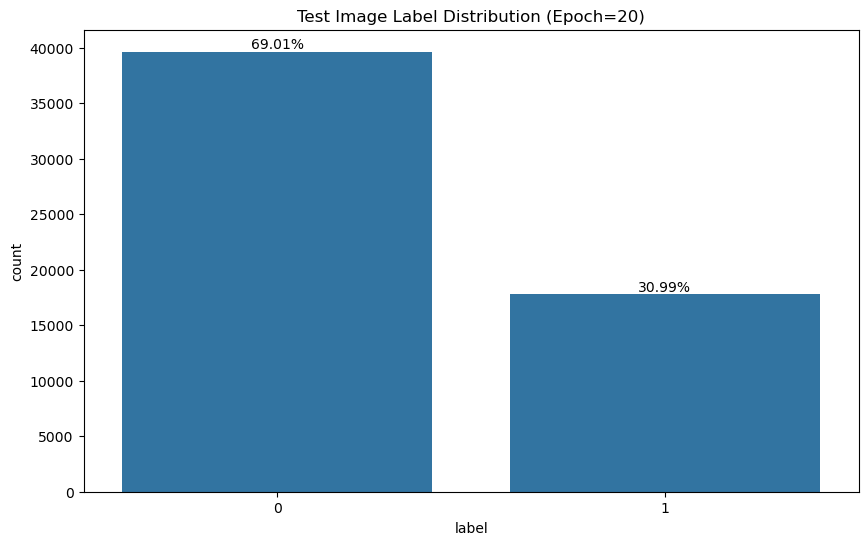

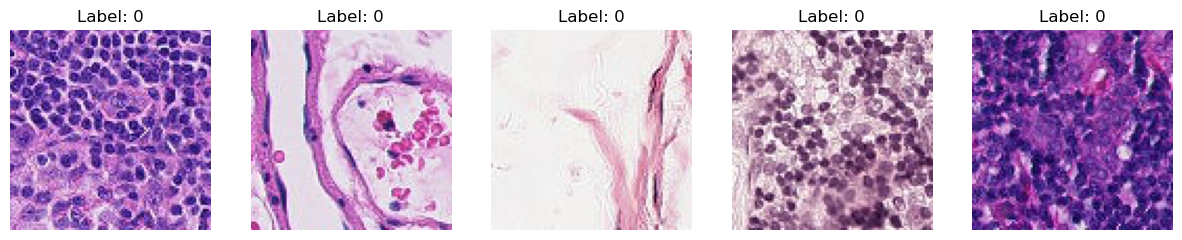

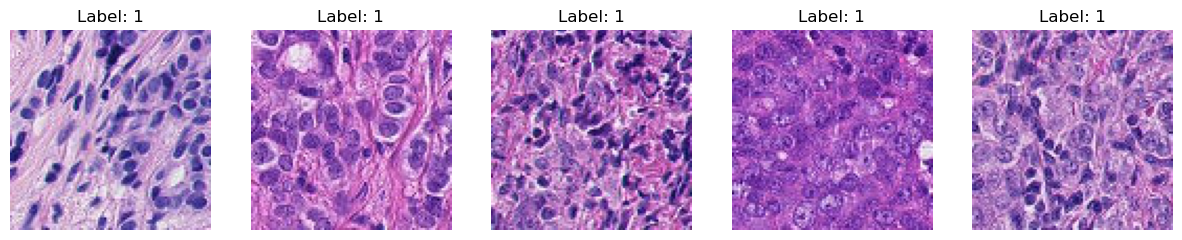

In [19]:
# Copy the submission dataframe to test_labels
test_labels = submission

# Calculate percentage of each label
label_counts = test_labels['label'].value_counts()
total_count = len(test_labels)
label_percentages = (label_counts / total_count) * 100

# Plot the label distribution
plt.figure(figsize=(10, 6))
ax = sns.countplot(x='label', data=test_labels)
plt.title("Test Image Label Distribution (Epoch=20)")

# Annotate with percentages
for p in ax.patches:
    height = p.get_height()
    percentage = label_percentages[p.get_x() + p.get_width() / 2.0]
    ax.annotate(f'{percentage:.2f}%', (p.get_x() + p.get_width() / 2., height), 
                ha='center', va='bottom')

plt.show()

# Display sample images for each label
display_sample_images(test_labels, 0, test_path)
display_sample_images(test_labels, 1, test_path)

# Results and Analysis
- With the improved model, we achieved 90.5% overall accuracy. The second method, with 20 epochs, took quite a bit longer than the version with only 10, but we gained 2% accuracy. However, the validation values vary wildly with the second training, which may indicate overfitting or issues with the learning rate.
- I initially struggled with the time it took to process this data, but after researching how to configure Python to use my GPU, things were much quicker. Leveraging the GPU's parallel processing is a huge advantage when processing large datasets.
- One note of interest to me was the distribution of labels between the training and test datasets. There was a 60/40 split in the training data, whereas the test data resulted in a 70/30 split, which means the model may be over-predicting for label 0. Generally, the trends seen in labeled data would repeat in unlabeled data of the same type. This may be due to calculation errors and the model's inability to identify the images correctly. Exploration of more advanced image processing solutions may yield better results.

# Conclusion
- Convolution Neural Networks are a powerful image processing tool. In this project, each layer of the CNN learned to recognize various features from each image. By detecting small features like edges of cells or more complex structures like cell membranes or nuclei, the layers combined to identify high-level features representing cancerous patterns. This technology
- Although late submissions are not permitted, my Public Score of 0.8236 would have ranked around 1,030th on the Kaggle Competition Leaderboard. This project gave me a deeper understanding of image-processing solutions and how to implement them. I also learned a lot about setting up Python environments with specific versions of libraries to enable deprecated features like Tensorflow GPU. This knowledge and configuration will pay dividends in future projects when large data sets are processed.

## References

[1] Histopathologic Cancer Detection:
- Will Cukierski, "Histopathologic Cancer Detection," Kaggle, 2018.
- https://kaggle.com/competitions/histopathologic-cancer-detection